In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 0 Time-series data exploration

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [4]:
df.shape

(10320, 2)

In [5]:
df = df.drop(columns = ['Unnamed: 0'],axis = 1)
df.index=pd.to_datetime(df.index)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


In [7]:
df.tail()

value
timestamp                 
2015-01-31 21:30:00  24670
2015-01-31 22:00:00  25721
2015-01-31 22:30:00  27309
2015-01-31 23:00:00  26591
2015-01-31 23:30:00  26288

<Axes: title={'center': 'Value results from July 2014 to January 2015.'}, xlabel='timestamp'>

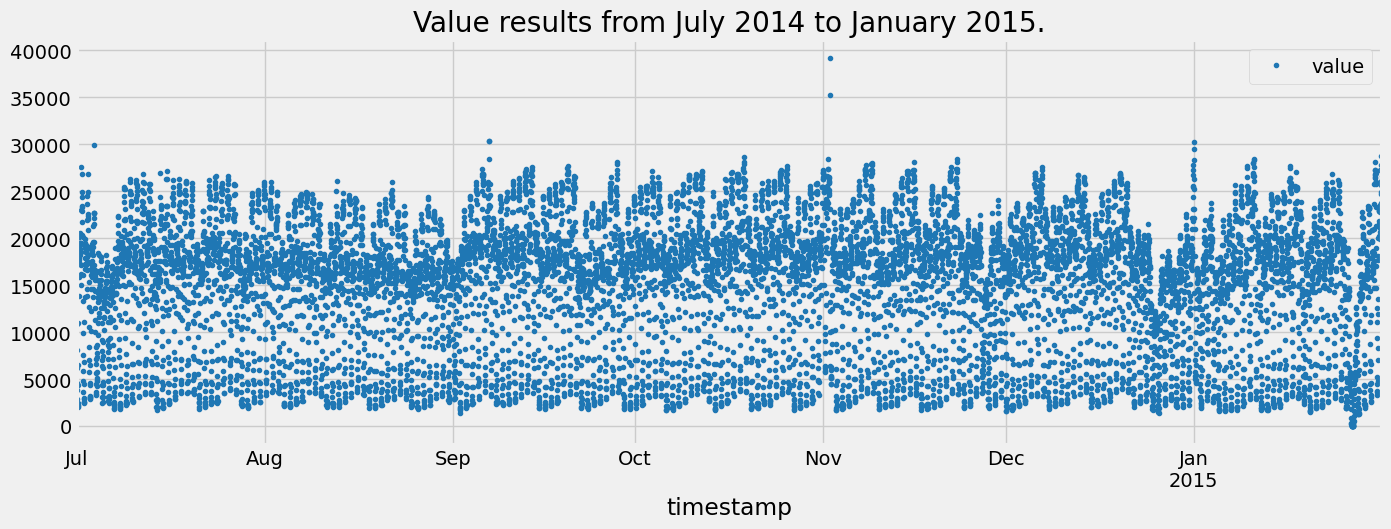

In [8]:
df.plot(style='.',
            figsize = (15,5),
            color = color_pal[0],
            title = 'Value results from July 2014 to January 2015.')

**Seasonal fluctuations:** value has recurring fluctuations with a periodicity of approximately one month.

**Trend:** There is no clear upward or downward trend, the values ​​fluctuate around a stable average level.

**Outliers:** Several outliers, especially around September and November, when value values ​​are significantly higher than the rest. These outliers may be caused by abnormal events or peaks in activity.

The second half of the graph (from about November) shows an increase in the spread of values, which may indicate increased variability or an increase in data volumes.

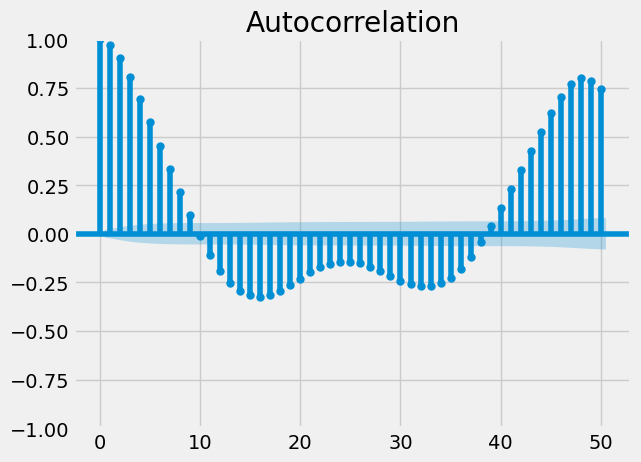

In [9]:
plot_acf(df['value'], lags=50)
plt.show()

There is both a trend and seasonality that should be taken into account when building predictive models.

The residuals in the data are random, indicating good decomposition.

<Axes: ylabel='Frequency'>

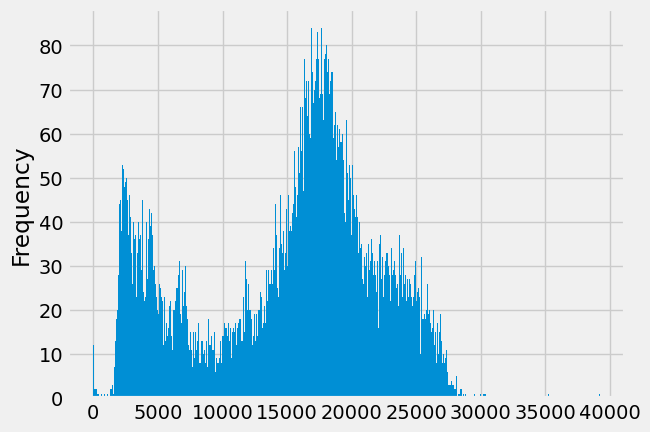

In [10]:
df['value'].plot(kind='hist', bins=500)

Values ​​above **30,000** are less common and can be considered outliers, they do not fit the underlying distribution.

In [11]:
df.isna().sum()

value    0
dtype: int64

<Axes: title={'center': 'Outliers'}, xlabel='timestamp'>

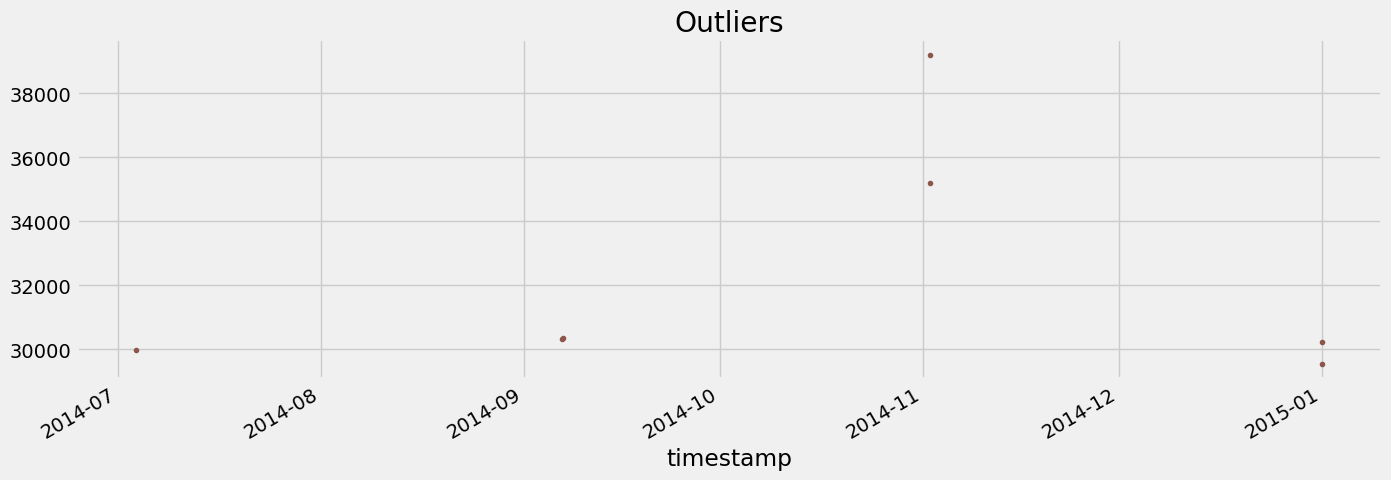

In [12]:
df.query('value > 29_000')['value'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [13]:
df = df.query('value < 29_000').copy()

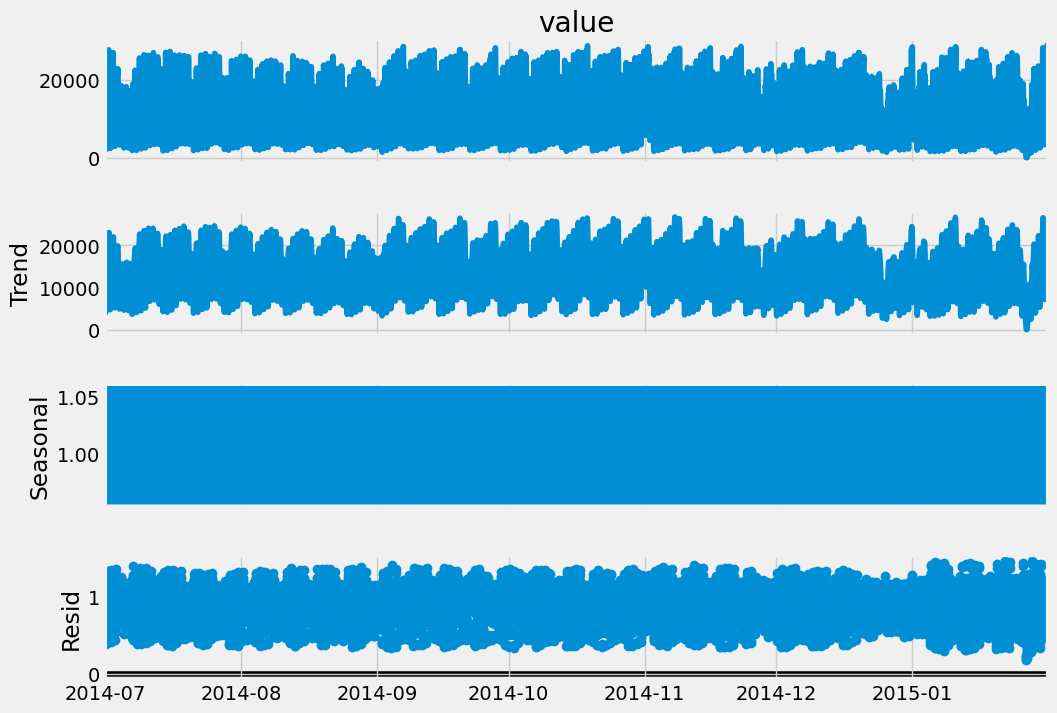

In [14]:
decomposition = seasonal_decompose(df['value'], model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [15]:
df.tail()

value
timestamp                 
2015-01-31 21:30:00  24670
2015-01-31 22:00:00  25721
2015-01-31 22:30:00  27309
2015-01-31 23:00:00  26591
2015-01-31 23:30:00  26288

<Axes: ylabel='Frequency'>

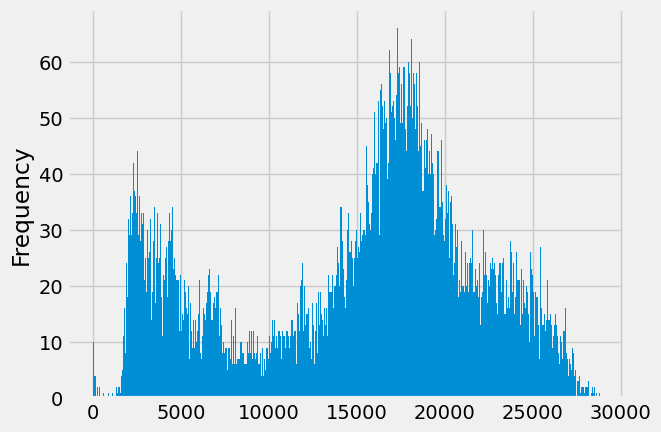

In [17]:
df['value'].plot(kind='hist', bins=500)

In [18]:
result = adfuller(df['value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

ADF Statistic: -10.64360914845311
p-value: 4.858794088085783e-19
Critical Values: {'1%': -3.4309867112571486, '5%': -2.861821389324224, '10%': -2.5669197783933826}


**p-value** is very low, we can **reject** the null hypothesis (Time series has a unit root is not stationary)

Time series is stable (stationary) and does not have a unit root.

We can use **XGBoost**.

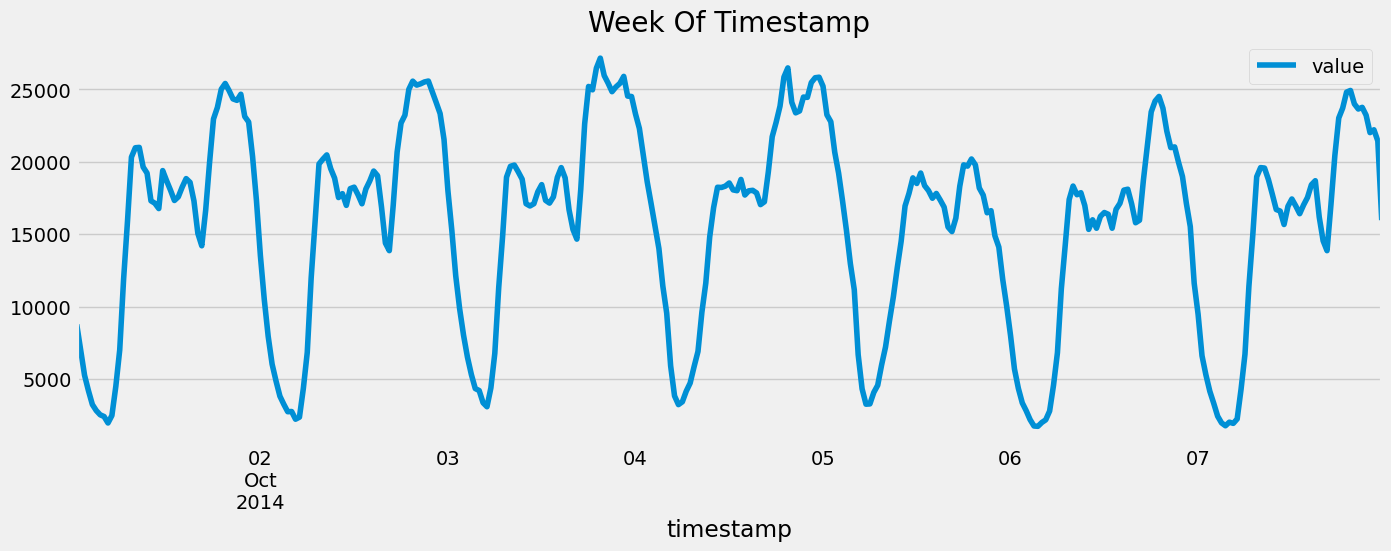

In [19]:
df.loc[(df.index > '10-01-2014') & (df.index < '10-08-2014')] \
    .plot(figsize=(15, 5), title='Week Of Timestamp')
plt.show()

# 1 Time Series Cross Validation

In [20]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*31*1, gap=24)
df = df.sort_index()

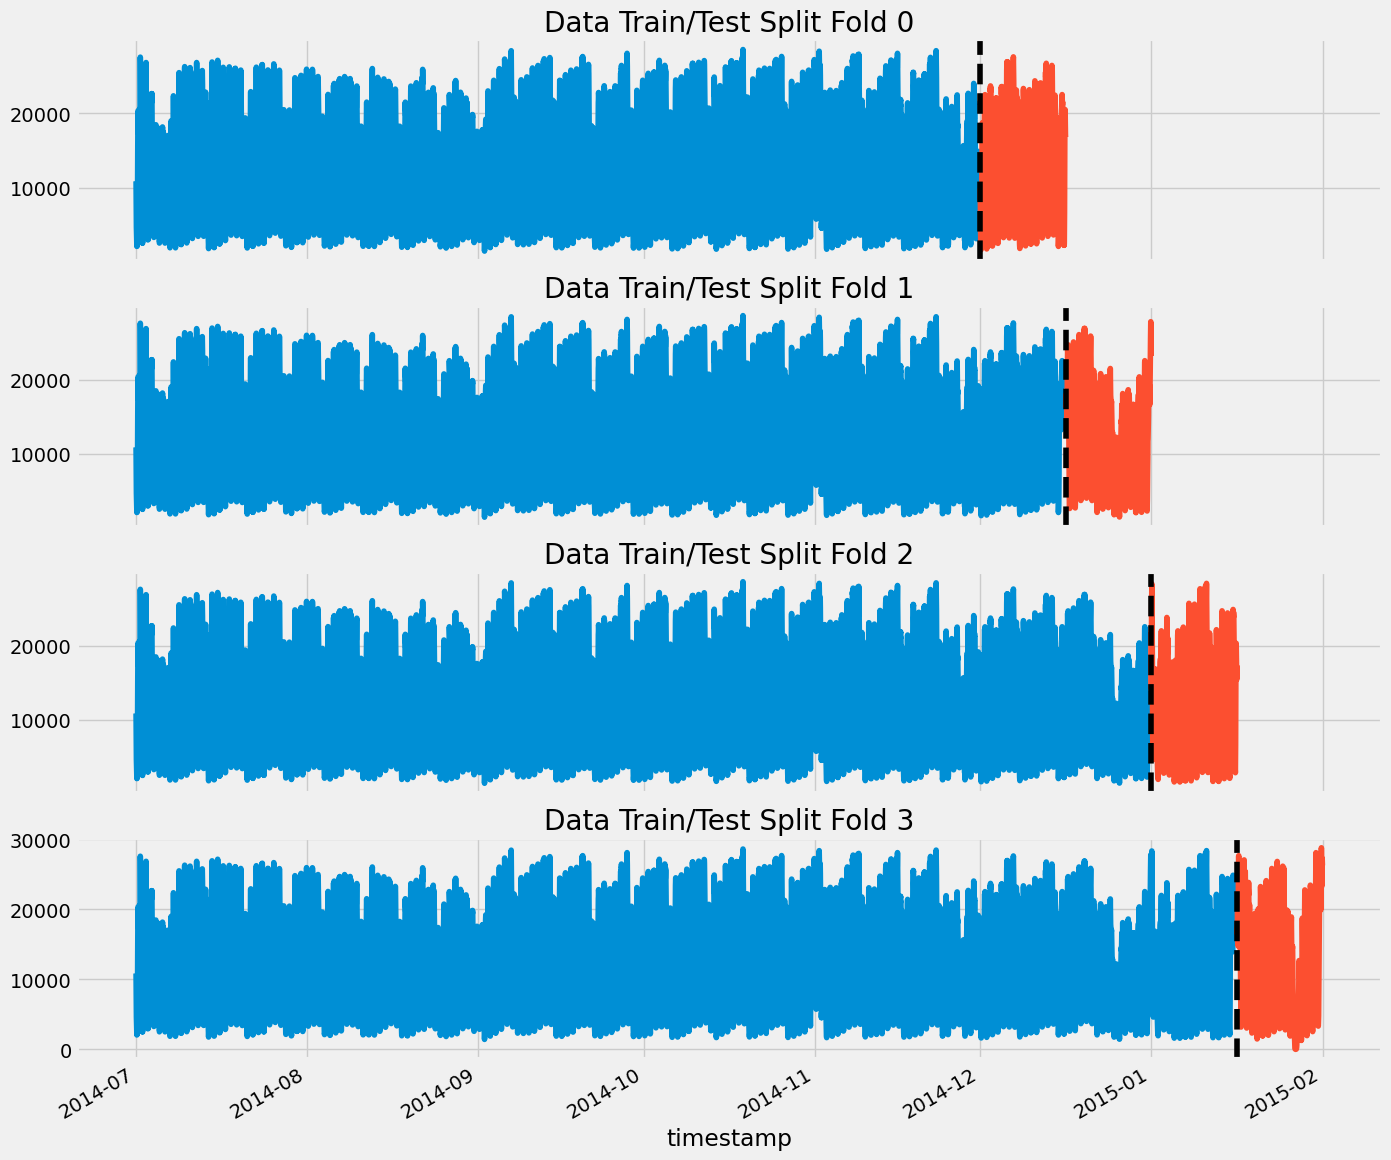

In [21]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2 Forecasting Horizon Explained

In [22]:
def create_features(df):
    df = df.copy()
    df['hour'] =  df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    return df

df = create_features(df)

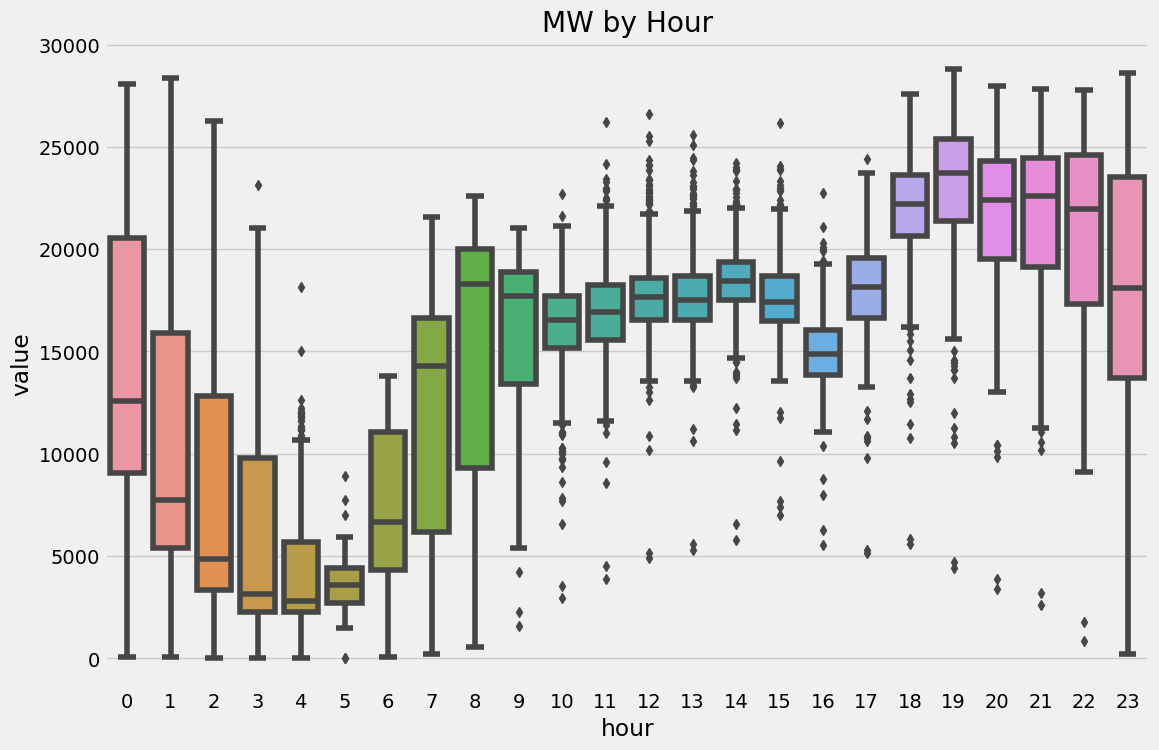

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=df, x='hour', y='value')
ax.set_title('MW by Hour')
plt.show()

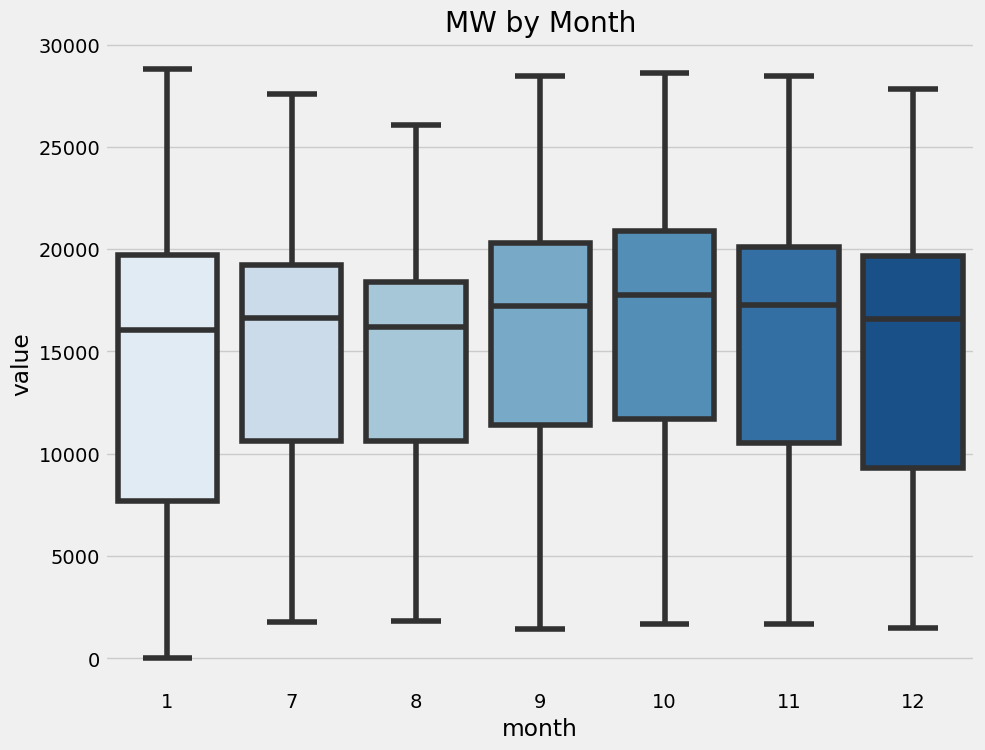

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='value', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# 3 Lag Features

In [25]:
def add_lags(df):
    target_map = df['value'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('32 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('64 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('96 days')).map(target_map)
    return df

In [26]:
df = add_lags(df)

In [27]:
df.tail()

value  hour  dayofweek  month  dayofmonth     lag1  \
timestamp                                                                 
2015-01-31 21:30:00  24670    21          5      1          31  20054.0   
2015-01-31 22:00:00  25721    22          5      1          31  19779.0   
2015-01-31 22:30:00  27309    22          5      1          31  18396.0   
2015-01-31 23:00:00  26591    23          5      1          31  17966.0   
2015-01-31 23:30:00  26288    23          5      1          31  15892.0   

                        lag2     lag3  
timestamp                              
2015-01-31 21:30:00  18416.0  20884.0  
2015-01-31 22:00:00  19806.0  19670.0  
2015-01-31 22:30:00  19671.0  18163.0  
2015-01-31 23:00:00  19234.0  15613.0  
2015-01-31 23:30:00  17725.0  13371.0

# 4  Train Using Cross Validation

In [28]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*31*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'month','dayofmonth',
                'lag1','lag2','lag3']

    TARGET = 'value'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:16636.96436	validation_1-rmse:17048.89074
[100]	validation_0-rmse:6790.21209	validation_1-rmse:6940.80941
[200]	validation_0-rmse:3570.70537	validation_1-rmse:3558.01028
[300]	validation_0-rmse:2717.22919	validation_1-rmse:2643.36609
[400]	validation_0-rmse:2442.04581	validation_1-rmse:2396.53993
[500]	validation_0-rmse:2301.05735	validation_1-rmse:2300.06116
[600]	validation_0-rmse:2187.66043	validation_1-rmse:2214.01131
[700]	validation_0-rmse:2123.98986	validation_1-rmse:2185.72272
[800]	validation_0-rmse:2040.29412	validation_1-rmse:2122.34477
[900]	validation_0-rmse:1984.32599	validation_1-rmse:2093.46420
[999]	validation_0-rmse:1913.78978	validation_1-rmse:2019.45932
[0]	validation_0-rmse:16686.48352	validation_1-rmse:15238.31050
[100]	validation_0-rmse:6800.18491	validation_1-rmse:5554.79514
[200]	validation_0-rmse:3567.19343	validation_1-rmse:3805.65647
[300]	validation_0-rmse:2687.55718	validation_1-rmse:3693.08175
[332]	validation_0-rmse:2579.17378	valid

In [29]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3488.6864
Fold scores:[2019.459318721092, 3666.6194397056543, 3768.4057701877373, 4500.261268043188]


The results show that the model performs well on average, but there is significant variation in prediction accuracy across folds.

It may be worth conducting further analysis to find out the reason for this variability. This may include optimizing hyperparameters, using different models, or adding additional features to improve stability and prediction accuracy.

# 5 Predicting the Future

In [30]:
df = create_features(df)

FEATURES =  ['hour', 'dayofweek', 'month',
                'lag1','lag2','lag3']
TARGET = 'value'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

[0]	validation_0-rmse:16479.33225
[100]	validation_0-rmse:6887.61817
[200]	validation_0-rmse:3876.05904
[300]	validation_0-rmse:3137.48367
[400]	validation_0-rmse:2866.23201
[499]	validation_0-rmse:2746.33930


In [31]:
df.index.max()

Timestamp('2015-01-31 23:30:00')

In [32]:
future = pd.date_range('2015-01-31','2015-02-28', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [33]:
future_w_features = df_and_future.query('isFuture').copy()

# 6 Predict the future

In [34]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

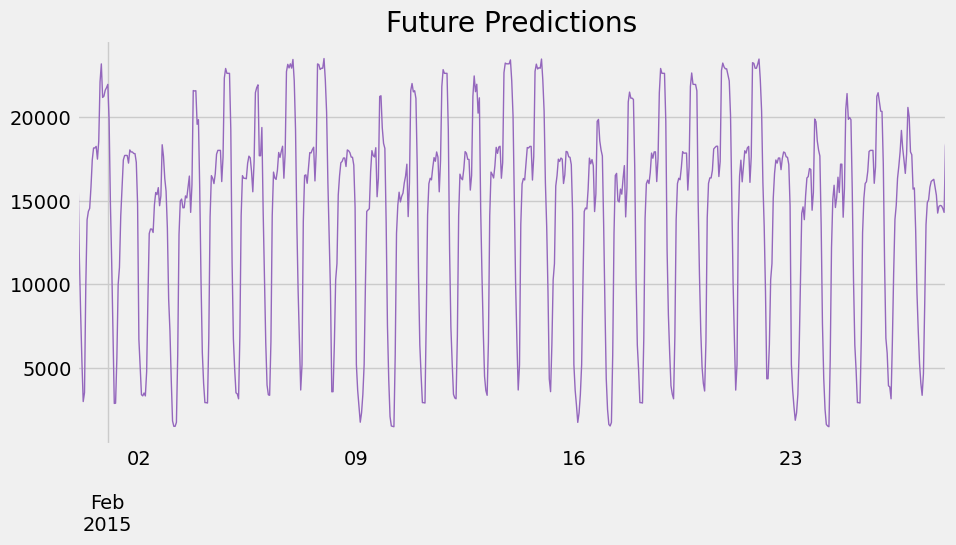

In [35]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()